In [7]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as pp
import numpy as np
from BlockedLeastSquares import BlockedLeastSquares

class ESN(object):
    def __init__(self, neurons, inputs, leak_rate, spectral_radius, dt, sparsity, noise):
        self.W_rec = np.random.randn(neurons, neurons)
        self.W_rec[np.random.rand(*self.W_rec.shape)<sparsity] = 0
        self.W_rec /= np.abs(np.linalg.eigvals(self.W_rec)).max()
        self.W_rec *= spectral_radius
        self.W_in = np.random.randn(neurons, inputs)*np.sqrt(np.pi/2) / inputs
        self.state = np.random.rand(neurons, 1)*2-1
        self.leak_rate = leak_rate
        self.spectral_radius = spectral_radius
        self.dt = dt
        self.sparsity = sparsity
        self.noise = noise
        self.neurons = neurons

    
    def _state_update(self, inp):
        self.state += self.dt*(-self.leak_rate*self.state + np.tanh(self.W_in.dot(inp.reshape((-1, 1))) + self.W_rec.dot(self.state))) + self.noise*np.random.randn(self.neurons, 1) 

    def train(self, data, targets, washout=0, block_size=10000):
        lstsq = BlockedLeastSquares()
        block_size = min(block_size, data.shape[0]-washout)
        block_num = int(np.ceil((data.shape[0]-washout)/block_size))
        print(block_num)
        # wash out initial network state
        for i, row in enumerate(data[:washout, :]):
            self._state_update(row)
                
        for j in range(block_num):
            block = data[washout+j*block_size:washout+(j+1)*block_size, :]
            state_values = np.empty((block.shape[0], self.neurons))
            for i, row in enumerate(block):
                self._state_update(row)
                state_values[i, :] = self.state.ravel()
            lstsq.update(targets[washout+j*block_size:washout+(j+1)*block_size, :], state_values)
            
        #self.readout_weights = np.linalg.lstsq(state_values, targets[washout:, :])[0].T 
        self.readout_weights = lstsq.omega.T
        
        predictions = self.predict(data)
        error = np.sqrt(((predictions-targets)**2 / targets.var(axis=0) ).mean())
        return error
    
    def predict(self, data, readout_weights=None):
        if readout_weights == None:
            readout_weights = self.readout_weights
        
        readout_values = np.empty((data.shape[0], readout_weights.shape[0]))
        for i,row in enumerate(data):
            self._state_update(row)
            readout_values[i, :] = readout_weights.dot(self.state).ravel()
        return readout_values

In [17]:
esn_params = dict(neurons=300, inputs=1, leak_rate=0.85, spectral_radius=0.95, dt=0.1, sparsity=0.5, noise=0.01)

net = ESN(**esn_params)

x= np.linspace(0, 10*np.pi, 10000).reshape((-1, 1))
y= np.sin(x)
z= np.cos(x)
y*=0.05


In [18]:
err= net.train(y, z, washout=0, block_size=10000)
print(err)
zz = net.predict(y)

1
0.361189422146


(-1.5, 1.5)

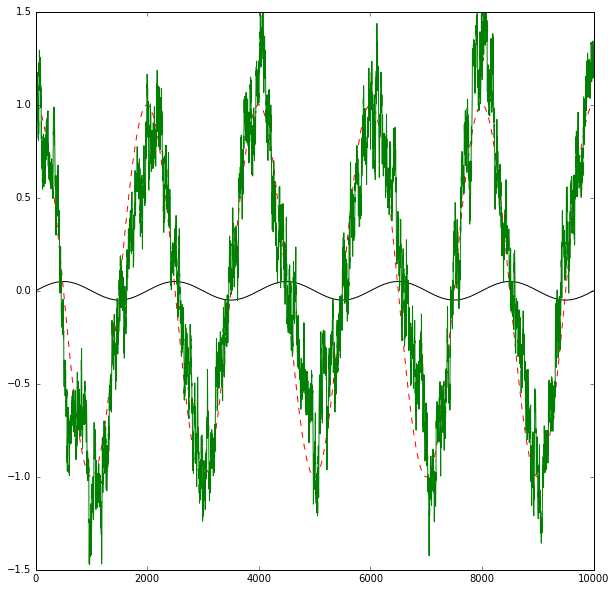

In [19]:
pp.figure(figsize=(10,10))
pp.plot(y, 'k-')
pp.plot(z, 'r--')
pp.plot(zz, 'g-')
pp.ylim([-1.5, 1.5])

/home/student/j/jleugeri/.local/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


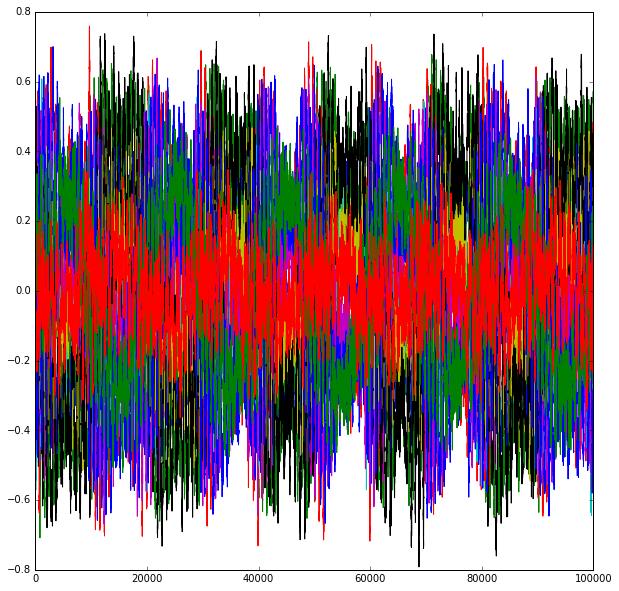

In [5]:
pp.figure(figsize=(10,10))
pp.plot(net.predict(y, readout_weights=np.eye(800,800)[:10,:]));

In [6]:
np.linalg.norm?